<a href="https://colab.research.google.com/github/JuanDanielEspinoza/termography/blob/main/keypoints/models/Pose_Estimation_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import yaml

data = {
    'path': '/content/drive/MyDrive/train_pose/train_pose',
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'kpt_shape': [17, 3],
    'names': {
        0: 'persona'
    }
}

with open('/content/drive/MyDrive/train_pose/train_pose/data.yaml', 'w') as file:
    yaml.dump(data, file,
              default_flow_style=False,
              sort_keys=False)


Y listo. Ya tenemos listo el set de datos y ya podemos comenzar a hacer la afinación.

## 5. Afinación de YOLO11 para detección de pose

Para poder acceder al modelo pre-entrenado debemos comenzar instalando la librería "ultralytics":

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

Y tan sólo debemos llevar a cabo estos dos pasos para afinar el modelo:

1. Importar el modelo pre-entrenado
2. Usar el método "train" para realizar la afinación

Por defecto en cada iteración de entrenamiento se almacenarán los pesos del modelo afinado en la carpeta "runs". Se recomienda realizar la afinación usando la GPU (aunque con la CPU es posible, simplemente se requerirá más tiempo):

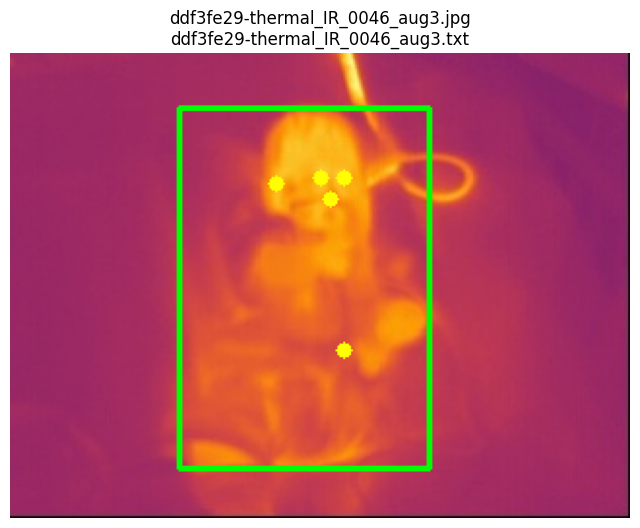

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

def plot_yolo_pose_labels(img_path, label_path):
    # Carga y conversión de la imagen
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"No se pudo leer la imagen: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Lectura de etiquetas
    if not os.path.isfile(label_path):
        raise FileNotFoundError(f"No se encontró el archivo de etiquetas: {label_path}")
    with open(label_path, 'r') as f:
        lines = f.readlines()

    # Dibujar cada anotación
    for line in lines:
        parts = line.strip().split()
        if len(parts) < 5:
            continue

        # Bounding box
        x_center, y_center, width, height = map(float, parts[1:5])
        x1 = int((x_center - width/2) * w)
        y1 = int((y_center - height/2) * h)
        x2 = int((x_center + width/2) * w)
        y2 = int((y_center + height/2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Keypoints
        kp = list(map(float, parts[5:]))
        for i in range(0, len(kp), 3):
            xk = int(kp[i] * w)
            yk = int(kp[i+1] * h)
            v  = kp[i+2]
            if v > 0:
                color = (255, 0, 0) if v == 1 else (255, 255, 0)
                cv2.circle(img, (xk, yk), 4, color, -1)

    # Mostrar con matplotlib
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{os.path.basename(img_path)}\n{os.path.basename(label_path)}")
    plt.show()


if __name__ == "__main__":
    # Rutas exactas a tu imagen y su etiqueta
    image_path = "/content/drive/MyDrive/train_pose/data_augmented/train/images/ddf3fe29-thermal_IR_0046_aug3.jpg"
    label_path = "/content/drive/MyDrive/train_pose/data_augmented/train/labels/ddf3fe29-thermal_IR_0046_aug3.txt"

    plot_yolo_pose_labels(image_path, label_path)


In [ ]:
from ultralytics import YOLO

# 1. Cargar el modelo (nano, el más pequeño)
model = YOLO("yolo11n-pose.pt")

# Afinar el modelo
results = model.train(data="/content/drive/MyDrive/train_pose/data_augmented/data.yaml",
                      epochs=400, # Número de iteraciones
                      patience=50, # Patience de early stopping
                      imgsz=(320,240), # Tamaño de las imágenes (máxima dimensión)
                      plots=True, # Guardar gráficos de entrenamiento
                      )

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/train_pose/data_augmented/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=400, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=(320, 240), int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-pose.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=50, perspec

train: Scanning /content/drive/MyDrive/train_pose/data_augmented/train/labels... 180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 180/180 [02:16<00:00,  1.32it/s]

train: New cache created: /content/drive/MyDrive/train_pose/data_augmented/train/labels.cache
WARNING ⚠️ No 'flip_idx' array defined in data.yaml, disabling 'fliplr' and 'flipud' augmentations.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.6±0.2 ms, read: 0.0±0.0 MB/s, size: 13.9 KB)


val: Scanning /content/drive/MyDrive/train_pose/data_augmented/val/labels... 48 images, 0 backgrounds, 0 corrupt: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]

val: New cache created: /content/drive/MyDrive/train_pose/data_augmented/val/labels.cache


Plotting labels to runs/pose/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/pose/train3
Starting training for 400 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/400      2.81G      1.907      9.592     0.7136      3.182      1.863          7        320: 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]

                   all         48         48      0.716      0.604      0.695      0.413     0.0742     0.0417    0.00583    0.00095



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/400      2.84G       1.47      7.975     0.4934      1.214      1.441         11        320: 100%|██████████| 12/12 [00:01<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

                   all         48         48      0.678      0.625      0.527       0.32     0.0884      0.104     0.0409    0.00508



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/400      2.86G       1.35      6.718     0.4894      1.001      1.349          9        320: 100%|██████████| 12/12 [00:02<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

                   all         48         48      0.959      0.583      0.676      0.433     0.0919     0.0625     0.0221    0.00703



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/400      2.87G      1.451      6.817     0.4348      1.081      1.406          6        320: 100%|██████████| 12/12 [00:02<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

                   all         48         48      0.445      0.785      0.578      0.315      0.315      0.167     0.0969     0.0192



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/400      2.89G      1.432      6.404     0.3976      1.049      1.392          6        320: 100%|██████████| 12/12 [00:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

                   all         48         48      0.541      0.787      0.683       0.35      0.303     0.0625     0.0258    0.00339



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/400      2.91G      1.389      5.774     0.4009     0.9584      1.376         11        320: 100%|██████████| 12/12 [00:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

                   all         48         48      0.785      0.604      0.725      0.382      0.374      0.311      0.215     0.0302



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/400      2.92G      1.388      5.661     0.3736     0.9681      1.372         12        320: 100%|██████████| 12/12 [00:01<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         48         48      0.732      0.604      0.646      0.374      0.429      0.312      0.205     0.0547



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/400      2.94G      1.389      5.332     0.3621     0.9724      1.367         13        320: 100%|██████████| 12/12 [00:02<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         48         48      0.657      0.667      0.758      0.382      0.182     0.0625     0.0272    0.00438



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/400      2.96G       1.34      4.957     0.3475     0.9676      1.355          5        320: 100%|██████████| 12/12 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         48         48      0.799      0.438      0.682      0.374      0.294      0.278      0.147      0.049



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/400      2.97G      1.332       5.15     0.3189     0.8909      1.335         10        320: 100%|██████████| 12/12 [00:01<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         48         48      0.691      0.699      0.756      0.391      0.496      0.292      0.198     0.0652



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/400      2.99G      1.346      5.179     0.3265     0.9063      1.326          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

                   all         48         48      0.817      0.562      0.641      0.317      0.333      0.188      0.105     0.0268



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/400         3G      1.329      5.084     0.3324     0.9243      1.311          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

                   all         48         48      0.844      0.667      0.837      0.449      0.566      0.292      0.196     0.0497



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/400      3.02G      1.241      5.013       0.33     0.8615      1.263          9        320: 100%|██████████| 12/12 [00:02<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         48         48      0.775      0.789      0.876      0.534      0.557      0.375      0.277     0.0897



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/400      3.04G      1.302      4.694     0.3085     0.8605      1.291         11        320: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

                   all         48         48      0.691      0.771       0.85      0.497      0.681      0.375      0.333     0.0615



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/400      3.05G       1.27      4.115     0.3327     0.8557      1.286         11        320: 100%|██████████| 12/12 [00:01<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]

                   all         48         48      0.975      0.583        0.8      0.474      0.411       0.25      0.145     0.0419



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/400      3.07G      1.283      4.455      0.316     0.8781      1.271          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.81it/s]

                   all         48         48      0.673      0.875      0.848       0.47      0.619      0.417      0.358      0.115



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/400      3.09G      1.258      4.549     0.3195     0.8692      1.281          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

                   all         48         48      0.677      0.655      0.634      0.378      0.265      0.229      0.124     0.0256



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/400       3.1G      1.258      4.599      0.309      0.857      1.278          3        320: 100%|██████████| 12/12 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         48         48      0.492      0.604      0.529       0.29      0.264      0.167     0.0969     0.0249



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/400      3.12G       1.26      4.244     0.3139     0.8467      1.276         11        320: 100%|██████████| 12/12 [00:02<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         48         48      0.667      0.792      0.748      0.412      0.436      0.333      0.263     0.0838



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/400      3.13G      1.223      4.064     0.3077     0.8213      1.249         10        320: 100%|██████████| 12/12 [00:01<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]

                   all         48         48      0.778      0.878      0.892      0.531      0.456      0.438      0.303       0.11



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/400      3.15G      1.192       4.15     0.3195     0.8061      1.261          5        320: 100%|██████████| 12/12 [00:01<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]

                   all         48         48      0.857      0.771      0.892      0.557      0.702      0.438      0.346      0.186



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/400      3.17G      1.193      3.915     0.2952      0.774      1.261          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]

                   all         48         48      0.779      0.807      0.858      0.558      0.845      0.542      0.536      0.233



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/400      3.19G      1.158      3.774     0.2853     0.7856      1.215          8        320: 100%|██████████| 12/12 [00:02<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         48         48      0.801      0.792      0.872      0.528      0.526      0.347      0.234      0.076



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/400       3.2G      1.167      4.006     0.2997     0.7872      1.208          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]

                   all         48         48      0.835      0.896      0.932      0.615      0.685      0.458      0.383      0.101



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/400      3.22G      1.142      3.925     0.2802     0.7273      1.201         12        320: 100%|██████████| 12/12 [00:01<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]

                   all         48         48      0.832      0.875      0.922       0.58      0.579      0.438      0.389      0.168



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/400      3.23G      1.156       4.13     0.2788     0.7661      1.226          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

                   all         48         48      0.957      0.916      0.932      0.578      0.594      0.542        0.4      0.152



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/400      3.25G      1.236      4.282     0.2911     0.8295      1.264          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

                   all         48         48      0.956      0.854      0.942      0.595      0.641      0.484      0.466      0.196



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/400      3.27G      1.169      3.929     0.2816     0.7428      1.216         11        320: 100%|██████████| 12/12 [00:02<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

                   all         48         48      0.954      0.812      0.905      0.569      0.576      0.479        0.4      0.219



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/400      3.28G      1.191      3.841     0.2664     0.7486      1.239          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

                   all         48         48      0.801      0.792      0.868      0.529      0.693      0.479      0.431      0.175



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/400       3.3G      1.169      3.705     0.2643     0.7305       1.21          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

                   all         48         48      0.893      0.869      0.929      0.633      0.834      0.562      0.562      0.242



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/400      3.32G      1.112      3.798     0.2712      0.722      1.198          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

                   all         48         48      0.857      0.812      0.927      0.637      0.845      0.542      0.557      0.256



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/400      3.33G      1.106      3.656     0.3005     0.7452      1.176          8        320: 100%|██████████| 12/12 [00:02<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         48         48      0.908      0.854      0.946      0.609      0.748      0.458      0.495      0.281



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/400      3.35G      1.044      3.601     0.2813     0.6711       1.15          7        320: 100%|██████████| 12/12 [00:02<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         48         48      0.893      0.869      0.933       0.61      0.519      0.521      0.367      0.166



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/400      3.37G        1.1      3.496     0.2705     0.7041      1.179          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]

                   all         48         48      0.982      0.875      0.957      0.633      0.599        0.5      0.405      0.218



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/400      3.38G      1.139      3.819     0.2701     0.7388      1.198          6        320: 100%|██████████| 12/12 [00:01<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.45it/s]

                   all         48         48      0.984      0.896      0.934      0.595      0.556        0.5      0.443      0.191



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/400       3.4G      1.125      3.798     0.2636     0.7429      1.216         10        320: 100%|██████████| 12/12 [00:01<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

                   all         48         48      0.871      0.875      0.928      0.579      0.626      0.417      0.338      0.166



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/400      3.41G      1.131      3.837     0.2709     0.7341      1.175         11        320: 100%|██████████| 12/12 [00:01<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

                   all         48         48      0.856      0.917       0.93      0.602      0.638      0.417      0.334      0.151



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/400      3.43G      1.111      3.629     0.2925     0.7631      1.201          6        320: 100%|██████████| 12/12 [00:02<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]

                   all         48         48      0.948      0.896      0.945      0.595      0.738      0.438      0.418      0.206



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/400      3.45G      1.079      3.517     0.2841     0.7144      1.148         12        320: 100%|██████████| 12/12 [00:01<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

                   all         48         48      0.947      0.896      0.943      0.601      0.985      0.583        0.6      0.279



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/400      3.46G      1.094      3.767     0.2603     0.7088      1.196         10        320: 100%|██████████| 12/12 [00:01<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

                   all         48         48      0.933      0.812      0.946      0.608      0.764      0.438      0.431      0.181



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/400      3.48G      1.085       3.47     0.2786     0.7106      1.172         11        320: 100%|██████████| 12/12 [00:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         48         48      0.953      0.896      0.965      0.606      0.751      0.438      0.432      0.242



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/400       3.5G      1.076      3.482     0.2686      0.703       1.17         12        320: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

                   all         48         48      0.923      0.938      0.983      0.641      0.599      0.521      0.382      0.137



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/400      3.51G      1.075      3.402     0.2683     0.6999      1.168          7        320: 100%|██████████| 12/12 [00:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         48         48      0.936       0.91      0.971      0.616      0.847      0.562      0.594      0.301



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/400      3.53G      1.006      3.429     0.2665     0.6847      1.142         11        320: 100%|██████████| 12/12 [00:01<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

                   all         48         48      0.877      0.854      0.921      0.644       0.83        0.5      0.502      0.267



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/400      3.54G      1.002       3.02     0.2599     0.6558      1.131         12        320: 100%|██████████| 12/12 [00:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]

                   all         48         48      0.783      0.833      0.887      0.589      0.931      0.521       0.56      0.251



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/400      3.56G      1.006      3.249     0.2642      0.693      1.146         13        320: 100%|██████████| 12/12 [00:01<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

                   all         48         48      0.892      0.854      0.921      0.603       0.95      0.521      0.548      0.266



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/400      3.58G      1.056      3.144     0.2576     0.6834      1.159         12        320: 100%|██████████| 12/12 [00:01<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         48         48      0.939      0.896      0.948      0.659      0.789      0.542      0.585      0.345



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/400      3.59G      1.043      3.159     0.2608     0.6825       1.14         10        320: 100%|██████████| 12/12 [00:02<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

                   all         48         48      0.936      0.908      0.967      0.644      0.721      0.542      0.559      0.301



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/400      3.61G      1.086       3.22     0.2593     0.7099      1.178          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

                   all         48         48      0.898      0.916      0.953      0.613      0.868      0.542      0.537       0.26



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/400      3.63G     0.9861      3.178     0.2568     0.6568      1.126          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]

                   all         48         48      0.902      0.958      0.967       0.62      0.687      0.438      0.359      0.143



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/400      3.64G      1.008      3.258     0.2637     0.6613      1.151         10        320: 100%|██████████| 12/12 [00:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

                   all         48         48      0.956      0.854      0.958      0.637       0.75        0.5      0.498      0.219



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/400      3.66G      1.031      3.473     0.2453     0.6445      1.127          9        320: 100%|██████████| 12/12 [00:02<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         48         48      0.932      0.875      0.941      0.621      0.902      0.576      0.607      0.293



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/400      3.68G     0.9892      3.246     0.2635     0.6467      1.114          9        320: 100%|██████████| 12/12 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         48         48      0.934      0.938      0.975      0.619      0.859      0.506      0.542      0.283



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/400      3.69G     0.9968      3.554     0.2634       0.67      1.122          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         48         48      0.923      0.875      0.954      0.637       0.81      0.479      0.499      0.241



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/400      3.71G     0.9854      3.164     0.2359     0.6477      1.101          5        320: 100%|██████████| 12/12 [00:01<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         48         48       0.97      0.917      0.983      0.667      0.784      0.583      0.573      0.316



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/400      3.73G     0.9733      2.876     0.2442     0.6524      1.106          6        320: 100%|██████████| 12/12 [00:01<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

                   all         48         48      0.838      0.854      0.908      0.597      0.762      0.535      0.525      0.286



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/400      3.74G     0.9717      3.303     0.2705     0.6457      1.089         14        320: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         48         48      0.882      0.934      0.957      0.644       0.65      0.562      0.521        0.3



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/400      3.76G     0.9817      3.016     0.2563     0.6343      1.134         10        320: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

                   all         48         48      0.984      0.854      0.976      0.659       0.79      0.562      0.594      0.316



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/400      3.78G     0.9831      2.971     0.2382     0.6376      1.143          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]

                   all         48         48      0.853      0.968      0.971      0.672      0.895        0.5      0.553      0.304



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/400      3.79G     0.9559      2.801     0.2518     0.6359      1.111          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         48         48      0.891      0.958      0.975      0.658      0.789      0.542      0.557      0.298



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/400      3.81G      1.003        3.4     0.2502     0.6658      1.103          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         48         48       0.81      0.888      0.952      0.636       0.62        0.5      0.435      0.195



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/400      3.82G      1.017      3.102     0.2571     0.6614      1.144         11        320: 100%|██████████| 12/12 [00:02<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         48         48      0.818      0.958      0.956      0.622      0.641      0.562      0.473      0.175



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/400      3.84G      1.037       3.23     0.2627     0.6741      1.175          6        320: 100%|██████████| 12/12 [00:01<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

                   all         48         48      0.912      0.865      0.954      0.631      0.491      0.438      0.351      0.162



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/400      3.86G      1.018      2.976     0.2426      0.665      1.133          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.34it/s]

                   all         48         48      0.962      0.917       0.97      0.673      0.692      0.562      0.545      0.258



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/400      3.87G     0.9535      2.807     0.2513     0.6252      1.105          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

                   all         48         48      0.952      0.938      0.971      0.588      0.762      0.521      0.584      0.275



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/400      3.89G      1.062       3.45     0.2458     0.6343      1.143         10        320: 100%|██████████| 12/12 [00:01<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

                   all         48         48      0.663      0.896      0.868      0.544      0.853      0.562      0.575       0.26



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/400      3.91G     0.9452      3.223     0.2691     0.6036      1.114          8        320: 100%|██████████| 12/12 [00:02<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         48         48      0.914      0.666      0.836      0.571      0.928      0.583      0.595      0.324



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/400      3.92G     0.9499      2.852     0.2321     0.6335      1.124          6        320: 100%|██████████| 12/12 [00:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

                   all         48         48      0.859      0.833      0.938      0.609      0.907      0.542      0.537      0.246



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/400      3.94G     0.9327      2.744     0.2354     0.6173      1.115         13        320: 100%|██████████| 12/12 [00:01<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]

                   all         48         48      0.906      0.917      0.949      0.624      0.806      0.434      0.421      0.182



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/400      3.96G     0.9455      3.181     0.2405     0.6355      1.107          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]

                   all         48         48      0.977      0.891      0.956      0.636      0.829        0.5      0.462      0.227



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/400      3.97G     0.9714      3.284     0.2521     0.6259      1.091         11        320: 100%|██████████| 12/12 [00:01<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

                   all         48         48      0.919      0.958      0.979      0.632      0.775      0.542      0.576      0.303



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/400      3.99G     0.9391       2.95     0.2283     0.6076      1.091          7        320: 100%|██████████| 12/12 [00:02<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]

                   all         48         48      0.917      0.979      0.985      0.647      0.889      0.542      0.542      0.281



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/400         4G     0.9743      2.874     0.2234     0.6659      1.113         11        320: 100%|██████████| 12/12 [00:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.49it/s]

                   all         48         48          1      0.907      0.988      0.661      0.642      0.562      0.566       0.28



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/400      4.02G     0.8809      3.017     0.2596     0.5981      1.077         11        320: 100%|██████████| 12/12 [00:01<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]

                   all         48         48      0.995      0.896      0.984       0.67       0.53      0.458      0.364      0.177



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/400      4.04G     0.9375      3.061      0.245     0.6262      1.115          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

                   all         48         48          1      0.894      0.988      0.669      0.677      0.583      0.558       0.31



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/400      4.05G     0.9674      3.221     0.2466     0.6327      1.125         11        320: 100%|██████████| 12/12 [00:01<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         48         48       0.99      0.979      0.994      0.681      0.638      0.562       0.43      0.239



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/400      4.07G     0.9365      3.111     0.2475     0.6243      1.109          9        320: 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         48         48      0.959      0.979       0.99      0.646      0.599      0.542      0.382      0.234



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/400      4.09G     0.9383      2.633     0.2317     0.6186      1.097         11        320: 100%|██████████| 12/12 [00:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

                   all         48         48      0.895      0.979      0.985      0.638      0.623      0.583      0.407      0.167



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/400       4.1G     0.9171      2.531     0.2281     0.5898      1.093         10        320: 100%|██████████| 12/12 [00:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

                   all         48         48        0.9      0.958       0.97      0.688      0.576      0.542      0.455      0.273



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/400      4.12G      0.926      2.643     0.2458     0.6188      1.106          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

                   all         48         48          1      0.952      0.993       0.67      0.606      0.458      0.457      0.234



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/400      4.13G     0.9584      2.804     0.2405     0.6222       1.11          6        320: 100%|██████████| 12/12 [00:02<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         48         48      0.956      0.915      0.978      0.646      0.924      0.521      0.568      0.325



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/400      4.15G     0.9465      2.889     0.2245     0.6207      1.109          8        320: 100%|██████████| 12/12 [00:02<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

                   all         48         48      0.926      0.854      0.942      0.606      0.733      0.458       0.48      0.239



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/400      4.17G      0.893      2.815     0.2173      0.592      1.057         16        320: 100%|██████████| 12/12 [00:01<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         48         48      0.834      0.943      0.953      0.615      0.631      0.542      0.476      0.251



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/400      4.19G      1.034      2.609     0.2142     0.6239       1.15          6        320: 100%|██████████| 12/12 [00:01<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]

                   all         48         48      0.887      0.875      0.973      0.608      0.564      0.521      0.457       0.23



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/400       4.2G     0.9463      2.939     0.2399     0.6197      1.103         12        320: 100%|██████████| 12/12 [00:01<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

                   all         48         48      0.991      0.938      0.987      0.623      0.551        0.5      0.448      0.259



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/400      4.22G     0.9006      2.862     0.2424     0.6057      1.081         11        320: 100%|██████████| 12/12 [00:02<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         48         48      0.916      0.905      0.965      0.659      0.767      0.521      0.567      0.342



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/400      4.23G     0.8752      2.594     0.2246     0.5848       1.07          9        320: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]

                   all         48         48      0.828      0.958      0.964      0.669      0.662      0.438      0.443      0.264



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/400      4.25G     0.8737      2.584      0.233     0.5761      1.067          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         48         48      0.919      0.952      0.976      0.628      0.518      0.542      0.414      0.245



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/400      4.27G     0.8773      2.559     0.2188     0.6093      1.066          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

                   all         48         48      0.956      0.958      0.989      0.635       0.58      0.583      0.426       0.24



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/400      4.28G     0.8848      2.666     0.2007     0.5696      1.059         12        320: 100%|██████████| 12/12 [00:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

                   all         48         48      0.973          1      0.995      0.633      0.587      0.604      0.522      0.217



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/400       4.3G     0.8916      2.579     0.2479     0.5984       1.08         10        320: 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         48         48      0.979      0.976      0.994      0.649      0.654      0.521      0.519       0.27



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/400      4.32G     0.8908      2.566     0.2296     0.5876       1.08         11        320: 100%|██████████| 12/12 [00:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

                   all         48         48      0.924      0.979      0.986      0.651      0.675      0.564      0.579      0.324



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/400      4.33G     0.8538      2.227     0.2068     0.5724      1.051          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]

                   all         48         48       0.99          1      0.995      0.664      0.671      0.604      0.563      0.348



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/400      4.35G     0.8641      2.369     0.2178     0.5436      1.068          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]

                   all         48         48      0.977      0.898      0.986      0.643       0.67      0.562      0.544      0.298



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/400      4.37G     0.9415      2.668     0.2217     0.6123      1.099         12        320: 100%|██████████| 12/12 [00:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

                   all         48         48      0.978       0.93      0.985      0.648      0.627      0.521      0.506      0.294



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/400      4.38G      0.852      2.334     0.2298     0.5711      1.067          5        320: 100%|██████████| 12/12 [00:02<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         48         48      0.971      0.979      0.992      0.657      0.675      0.562      0.506      0.286



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/400       4.4G     0.8563      2.478     0.2081     0.5696      1.035          8        320: 100%|██████████| 12/12 [00:02<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         48         48      0.965      0.896      0.983       0.66      0.701      0.521      0.544      0.234



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/400      4.41G     0.8645      2.623     0.2103     0.5936       1.05          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]

                   all         48         48      0.963      0.896      0.969      0.652      0.768      0.521       0.56      0.272



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/400      4.43G     0.8877      2.372      0.196     0.5763      1.073          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]

                   all         48         48      0.974      0.896      0.977       0.66      0.663        0.5       0.51      0.244



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/400      4.45G     0.8884      2.586     0.2209     0.5874      1.082          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

                   all         48         48          1       0.89      0.983      0.679      0.705      0.542      0.568      0.292



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    101/400      4.46G     0.8864      2.509     0.2025     0.6008      1.058          7        320: 100%|██████████| 12/12 [00:02<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]


                   all         48         48      0.958      0.979      0.991      0.671      0.657      0.562      0.466      0.227

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    102/400      4.48G     0.8756      2.514     0.2196     0.5414      1.056         11        320: 100%|██████████| 12/12 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]

                   all         48         48          1      0.975      0.995      0.687      0.699      0.604      0.481      0.297



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    103/400       4.5G     0.8211      2.229     0.2128     0.5427      1.035         14        320: 100%|██████████| 12/12 [00:01<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.90it/s]

                   all         48         48      0.979      0.981      0.995      0.697      0.679      0.562      0.505      0.306



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    104/400      4.51G     0.8483      2.416     0.2154     0.5565      1.055          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.89it/s]

                   all         48         48      0.978      0.958      0.991      0.694      0.616      0.542       0.47      0.268



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    105/400      4.53G     0.8401      2.724     0.2181     0.5599      1.065          6        320: 100%|██████████| 12/12 [00:01<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

                   all         48         48      0.958      0.917      0.986      0.683      0.618      0.574      0.535      0.328



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    106/400      4.54G     0.8524      2.464     0.2218     0.5546      1.071          9        320: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         48         48      0.959      0.973      0.991      0.675      0.648      0.521       0.47      0.255



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    107/400      4.56G     0.8171      2.277     0.2107      0.536      1.038          7        320: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]

                   all         48         48      0.979      0.974      0.991      0.657      0.678      0.526      0.477      0.237



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    108/400      4.58G     0.8203      2.544     0.2137     0.5374      1.039         13        320: 100%|██████████| 12/12 [00:01<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.83it/s]

                   all         48         48      0.979      0.974      0.989      0.709      0.647      0.521      0.527       0.25



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    109/400      4.59G     0.8525      2.449     0.2151     0.5426      1.035         11        320: 100%|██████████| 12/12 [00:01<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         48         48      0.913      0.938      0.972      0.661      0.716      0.583      0.597      0.331



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    110/400      4.61G     0.8806      2.597     0.2192     0.5796      1.063          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

                   all         48         48      0.876      0.884      0.942      0.638      0.793      0.542      0.578      0.291



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    111/400      4.63G     0.8515      2.625     0.2378     0.5511      1.049         14        320: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         48         48      0.873      0.896      0.935      0.653       0.71      0.521      0.513      0.305



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    112/400      4.64G     0.8564      2.761     0.2207     0.5491      1.053         12        320: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

                   all         48         48      0.863      0.854      0.933      0.617      0.611      0.562      0.496      0.258



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    113/400      4.66G     0.8558      2.643     0.2136     0.5489      1.063          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

                   all         48         48      0.851      0.958      0.969      0.635      0.599      0.521      0.484      0.275



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    114/400      4.68G     0.8488      2.123     0.1993     0.5404      1.052         16        320: 100%|██████████| 12/12 [00:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         48         48      0.938      0.951      0.971      0.628      0.789      0.583      0.633      0.382



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    115/400      4.69G     0.8454       2.47      0.209     0.5577      1.062          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

                   all         48         48      0.944      0.896      0.964      0.607      0.886      0.521      0.576      0.331



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    116/400      4.71G     0.8119      2.353     0.2231     0.5383       1.06         10        320: 100%|██████████| 12/12 [00:02<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         48         48      0.816      0.938      0.944      0.638      0.896      0.562      0.591      0.321



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    117/400      4.72G     0.8647      2.278     0.2276     0.5543      1.071         14        320: 100%|██████████| 12/12 [00:02<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

                   all         48         48      0.968      0.917      0.974      0.653      0.912      0.583      0.617      0.368



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    118/400      4.74G     0.8175      2.459     0.2041     0.5452       1.04          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         48         48      0.991      0.938       0.99      0.687      0.981      0.583      0.614      0.358



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    119/400      4.76G     0.8507      2.428     0.2016     0.5487      1.058         13        320: 100%|██████████| 12/12 [00:01<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

                   all         48         48      0.979      0.954      0.985      0.704      0.942      0.521      0.569      0.372



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    120/400      4.78G     0.8449      2.575     0.2195     0.5499       1.05          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.22it/s]

                   all         48         48      0.996      0.979      0.993      0.673      0.886      0.484      0.512        0.3



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    121/400      4.79G     0.8584      2.506     0.2127     0.5559      1.046          8        320: 100%|██████████| 12/12 [00:02<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

                   all         48         48      0.946      0.958      0.979      0.668          1      0.578      0.606      0.338



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    122/400      4.81G     0.8512      2.532      0.209     0.5564      1.055          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

                   all         48         48      0.939          1      0.986      0.668      0.784      0.542      0.534      0.269



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    123/400      4.82G      0.846      2.594     0.2192     0.5703      1.028          5        320: 100%|██████████| 12/12 [00:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.85it/s]

                   all         48         48      0.921      0.977      0.982      0.664      0.636      0.562      0.405      0.248



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    124/400      4.84G     0.8513      2.499     0.2145     0.5447      1.053          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         48         48      0.899      0.958      0.974      0.667      0.703      0.583      0.465      0.289



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    125/400      4.86G     0.7917      2.331       0.21     0.5134      1.016          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]

                   all         48         48      0.957      0.925      0.982      0.697       0.74      0.562      0.494      0.314



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    126/400      4.87G     0.7789      1.987     0.2134     0.5077      1.022         11        320: 100%|██████████| 12/12 [00:02<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

                   all         48         48      0.887      0.985      0.985      0.684      0.742      0.542      0.568      0.327



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    127/400      4.89G     0.8038      2.453     0.2166     0.5384      1.041          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

                   all         48         48      0.909          1       0.99      0.656      0.731      0.566      0.612      0.311



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    128/400      4.91G     0.7652      2.447     0.2169      0.505       1.02          6        320: 100%|██████████| 12/12 [00:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]

                   all         48         48      0.991      0.979      0.995      0.642      0.614      0.479      0.512      0.264



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    129/400      4.92G     0.8228      2.532     0.2012     0.5297       1.06          5        320: 100%|██████████| 12/12 [00:01<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.03it/s]

                   all         48         48      0.948      0.979      0.993      0.643      0.664      0.542       0.57        0.3



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    130/400      4.94G     0.8076      2.397     0.2062     0.5518      1.027          7        320: 100%|██████████| 12/12 [00:02<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]


                   all         48         48       0.96          1      0.993      0.666      0.632      0.542      0.572      0.313

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    131/400      4.96G     0.8027      2.156     0.2063     0.5386      1.047         11        320: 100%|██████████| 12/12 [00:02<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

                   all         48         48      0.919      0.979      0.974      0.674      0.607      0.521      0.567      0.342



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    132/400      4.97G     0.8192      2.322     0.2026     0.5317      1.055          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

                   all         48         48      0.972      0.979      0.992      0.684      0.652      0.562      0.582      0.312



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    133/400      4.99G     0.7812      2.456     0.2188     0.5095      1.026         12        320: 100%|██████████| 12/12 [00:01<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

                   all         48         48      0.923      0.996       0.99       0.68      0.668      0.562      0.592      0.351



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    134/400         5G     0.7774      2.773     0.2149     0.5148       1.02         13        320: 100%|██████████| 12/12 [00:01<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         48         48      0.958      0.951      0.985       0.66      0.674       0.56      0.569      0.304



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    135/400      5.02G     0.7593      2.316     0.2207     0.5202      1.015          4        320: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

                   all         48         48      0.975      0.896      0.982      0.659      0.658        0.5      0.513      0.276



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    136/400      5.04G     0.7495      2.199     0.2211     0.4964      1.007          7        320: 100%|██████████| 12/12 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

                   all         48         48          1      0.957      0.992      0.679      0.804      0.562      0.633      0.385



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    137/400      5.05G      0.763      2.457     0.2012     0.5029      1.013          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

                   all         48         48       0.96      0.991      0.993      0.672      0.748        0.5       0.56      0.339



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    138/400      5.07G     0.7622      2.287     0.2096     0.5031      1.012         12        320: 100%|██████████| 12/12 [00:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]

                   all         48         48      0.891      0.958      0.973      0.662      0.712      0.542      0.564      0.344



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    139/400      5.09G     0.7421      2.278     0.1954     0.4922      1.003         10        320: 100%|██████████| 12/12 [00:02<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         48         48      0.885      0.961       0.98      0.666      0.596        0.5      0.455      0.261



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    140/400       5.1G     0.7888      2.114     0.2026     0.4882      1.018          7        320: 100%|██████████| 12/12 [00:03<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         48         48      0.939      0.964      0.986      0.672      0.623      0.479      0.507      0.325



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    141/400      5.12G      0.767      2.119     0.2007     0.5075       1.02          7        320: 100%|██████████| 12/12 [00:02<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

                   all         48         48      0.954      0.979      0.976       0.68      0.633      0.539      0.547      0.327



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    142/400      5.13G     0.7903      2.611     0.1945      0.518      1.021         11        320: 100%|██████████| 12/12 [00:01<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]

                   all         48         48      0.979      0.953      0.981      0.681      0.588      0.604      0.526      0.326



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    143/400      5.15G     0.7757      2.582     0.1951     0.5146      1.032          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

                   all         48         48      0.977      0.958      0.981      0.698      0.668      0.542      0.587      0.341



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    144/400      5.17G     0.7624      2.058     0.1784     0.5044      1.022          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         48         48       0.97          1      0.994      0.704      0.662      0.521      0.594      0.358



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    145/400      5.18G     0.7579      2.441     0.1939     0.4963      1.018          8        320: 100%|██████████| 12/12 [00:02<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         48         48       0.97      0.979      0.988      0.706      0.671      0.521      0.569      0.343



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    146/400       5.2G     0.7353      2.206     0.2142     0.5047      1.021          6        320: 100%|██████████| 12/12 [00:02<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         48         48      0.979      0.985      0.994      0.676        0.6        0.5       0.52      0.259



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    147/400      5.22G     0.7651      2.224     0.1964     0.5203      1.023          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

                   all         48         48          1      0.976      0.992      0.676      0.669      0.542      0.597      0.363



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    148/400      5.23G     0.7791      2.187     0.1909     0.5325      1.034          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

                   all         48         48      0.979      0.976      0.993        0.7      0.669      0.542      0.613      0.302



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    149/400      5.25G     0.7708      2.288     0.1971     0.4991     0.9953         11        320: 100%|██████████| 12/12 [00:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         48         48      0.972      0.938      0.981      0.714      0.664      0.542      0.571       0.37



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    150/400      5.27G     0.8188      2.416     0.2032     0.5157      1.034          5        320: 100%|██████████| 12/12 [00:02<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

                   all         48         48      0.932      0.958      0.981      0.669      0.668      0.562      0.595       0.36



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    151/400      5.28G      0.819      2.344     0.1991     0.5131      1.025          6        320: 100%|██████████| 12/12 [00:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

                   all         48         48       0.97      0.938      0.987      0.676      0.684      0.604      0.579      0.316



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    152/400       5.3G     0.7627      2.418     0.1935     0.5012      1.008          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

                   all         48         48      0.958      0.979      0.992      0.709      0.621      0.547      0.442      0.259



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    153/400      5.31G     0.7807      2.128     0.2024     0.5167      1.033          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]

                   all         48         48      0.978          1      0.994      0.661        0.6      0.562      0.448      0.255



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    154/400      5.33G     0.7783      2.474      0.201     0.5019      1.035          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

                   all         48         48      0.972          1      0.994      0.675      0.607      0.625      0.476      0.261



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    155/400      5.35G     0.7666      1.971     0.1901     0.5066      1.008          8        320: 100%|██████████| 12/12 [00:02<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]

                   all         48         48       0.98          1      0.995      0.678      0.673      0.583      0.588      0.343



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    156/400      5.37G     0.7315      2.315     0.1867     0.4737      1.015          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

                   all         48         48      0.974      0.979      0.994      0.687      0.699       0.58      0.617        0.4



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    157/400      5.38G     0.7314      2.032     0.1826     0.5037      1.021          5        320: 100%|██████████| 12/12 [00:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

                   all         48         48      0.959          1      0.993      0.685       0.66      0.562      0.626      0.359



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    158/400       5.4G     0.7248      1.921     0.1751      0.496      1.006         10        320: 100%|██████████| 12/12 [00:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

                   all         48         48      0.957      0.958       0.99      0.674      0.635      0.562      0.533      0.302



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    159/400      5.41G     0.7269      2.218     0.2064      0.465      1.014          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         48         48      0.972      0.958       0.99      0.696      0.617      0.562      0.447      0.252



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    160/400      5.43G       0.77      2.387     0.1996     0.5086      1.033          8        320: 100%|██████████| 12/12 [00:02<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

                   all         48         48      0.924      0.938      0.982      0.706      0.671      0.562      0.522      0.349



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    161/400      5.45G     0.7732      2.376     0.1928     0.5114      1.018          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

                   all         48         48      0.927      0.896      0.978      0.692      0.698      0.479      0.489      0.303



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    162/400      5.46G     0.7715      2.195     0.2032      0.514      1.014         13        320: 100%|██████████| 12/12 [00:01<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

                   all         48         48      0.913      0.958      0.974      0.683      0.766      0.546      0.577      0.298



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    163/400      5.48G     0.7822      2.148     0.2072      0.526      1.037          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

                   all         48         48      0.978      0.946      0.983      0.667      0.648      0.538      0.487      0.248



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    164/400       5.5G     0.7618      2.272      0.203     0.4759      1.002         10        320: 100%|██████████| 12/12 [00:02<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]

                   all         48         48      0.957      0.921      0.986      0.662      0.578      0.542      0.434      0.258



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    165/400      5.51G     0.7588      2.175     0.1933     0.4969     0.9933          8        320: 100%|██████████| 12/12 [00:02<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

                   all         48         48      0.913      0.979      0.988      0.681      0.636      0.583      0.459      0.268



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    166/400      5.53G     0.8187      2.425     0.1922     0.5546      1.042          6        320: 100%|██████████| 12/12 [00:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

                   all         48         48      0.919      0.979      0.986      0.686       0.45      0.479      0.288      0.178



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    167/400      5.54G      0.767      2.342     0.2002     0.5114      1.021          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]

                   all         48         48      0.957      0.939      0.989      0.714      0.624      0.562      0.478       0.27



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    168/400      5.56G     0.7435      2.277     0.1891     0.5212     0.9972          4        320: 100%|██████████| 12/12 [00:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

                   all         48         48      0.958      0.979      0.992      0.716      0.545        0.5      0.384      0.226



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    169/400      5.58G     0.8042      2.317     0.2125     0.5319      1.044          5        320: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

                   all         48         48          1      0.975      0.993      0.698       0.58      0.521      0.522      0.322



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    170/400      5.59G     0.7476      2.077     0.1892     0.5103      1.004         11        320: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

                   all         48         48      0.959      0.976      0.991      0.679      0.582      0.583      0.583      0.371



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    171/400      5.61G     0.7315       2.16     0.1978     0.4911     0.9924         14        320: 100%|██████████| 12/12 [00:01<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

                   all         48         48       0.94      0.976      0.983      0.681      0.487        0.5       0.44      0.248



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    172/400      5.63G     0.7399      2.378     0.2068     0.4978      1.006          5        320: 100%|██████████| 12/12 [00:01<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.34it/s]

                   all         48         48      0.921      0.976      0.981      0.695       0.65      0.458      0.481      0.241



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    173/400      5.64G     0.7558       2.23     0.1973     0.4938      1.018         12        320: 100%|██████████| 12/12 [00:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

                   all         48         48      0.978      0.937      0.982      0.694      0.566      0.488      0.447      0.244



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    174/400      5.66G     0.7493      2.373      0.182     0.4984     0.9951         10        320: 100%|██████████| 12/12 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         48         48      0.976      0.958      0.984      0.715      0.571      0.562       0.52       0.28



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    175/400      5.68G     0.7849      2.312     0.1859     0.5178      1.016         10        320: 100%|██████████| 12/12 [00:02<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

                   all         48         48      0.975      0.958      0.986      0.693      0.538      0.521      0.431      0.242



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    176/400      5.69G     0.6977      2.068     0.1965     0.4695     0.9959          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.34it/s]

                   all         48         48      0.984      0.917      0.988      0.683      0.531      0.479      0.364      0.205



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    177/400      5.71G     0.7183       2.23      0.189     0.4605     0.9938         11        320: 100%|██████████| 12/12 [00:01<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         48         48      0.994      0.938      0.984        0.7      0.624      0.562      0.464      0.271



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    178/400      5.72G     0.7323      2.314     0.1854     0.4845     0.9844          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

                   all         48         48      0.957      0.931      0.981      0.686      0.616      0.534      0.462      0.281



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    179/400      5.74G     0.7232      2.177     0.1993     0.4848      1.006          5        320: 100%|██████████| 12/12 [00:02<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         48         48      0.959      0.975      0.991      0.693      0.623      0.542      0.516      0.299



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    180/400      5.76G     0.7061      2.016     0.1911     0.4738      0.988          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.34it/s]

                   all         48         48      0.959          1      0.994      0.686      0.647      0.583      0.554      0.323



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    181/400      5.77G     0.7105      2.211      0.197     0.4711     0.9869          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         48         48      0.959          1      0.991      0.683      0.643      0.583      0.558      0.287



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    182/400      5.79G     0.7238      2.278     0.1816     0.4798     0.9835          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         48         48      0.998      0.979      0.995      0.706      0.603      0.569      0.537      0.305



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    183/400      5.81G      0.702      2.191     0.1973     0.5095     0.9875          5        320: 100%|██████████| 12/12 [00:01<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]

                   all         48         48          1       0.99      0.995      0.727      0.583      0.583      0.534      0.314



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    184/400      5.82G     0.7073      2.049     0.2029     0.4902     0.9939         12        320: 100%|██████████| 12/12 [00:02<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

                   all         48         48      0.994      0.958      0.993      0.729      0.715        0.5      0.556      0.311



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    185/400      5.84G      0.701      2.117     0.1954     0.4655     0.9806          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]

                   all         48         48      0.998      0.979      0.994      0.718      0.573      0.562      0.556      0.337



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    186/400      5.86G     0.6703      2.094     0.1875      0.458     0.9575         12        320: 100%|██████████| 12/12 [00:01<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         48         48      0.979      0.974      0.992      0.714      0.568      0.542      0.445      0.275



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    187/400      5.87G     0.6672       1.98     0.1844     0.4631     0.9693         13        320: 100%|██████████| 12/12 [00:01<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]


                   all         48         48      0.975      0.979      0.991      0.728      0.561      0.562      0.398      0.244

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    188/400      5.89G     0.7031      1.811     0.1862     0.4722      0.996          9        320: 100%|██████████| 12/12 [00:03<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         48         48      0.996      0.979      0.994      0.715      0.576      0.562      0.397      0.259



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    189/400      5.91G     0.6887      2.002     0.1966     0.4788     0.9778          9        320: 100%|██████████| 12/12 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

                   all         48         48      0.996      0.979      0.994      0.725      0.583      0.521      0.453      0.304



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    190/400      5.92G     0.7011      2.011     0.1849      0.469      1.001          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.49it/s]

                   all         48         48      0.979      0.994      0.995      0.713      0.587      0.604      0.521      0.299



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    191/400      5.94G     0.6794      1.931     0.1885     0.4563     0.9614         14        320: 100%|██████████| 12/12 [00:01<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

                   all         48         48      0.977      0.979      0.993       0.73      0.641      0.542      0.618      0.323



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    192/400      5.96G     0.6718      2.042     0.1887     0.4455     0.9787          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

                   all         48         48      0.957      0.934      0.987      0.729      0.707      0.542      0.643      0.385



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    193/400      5.97G     0.7286      1.976     0.1892     0.4779     0.9927          8        320: 100%|██████████| 12/12 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         48         48       0.94      0.978       0.99      0.711      0.721      0.479       0.56      0.348



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    194/400      5.99G     0.6801      2.005      0.197     0.4496     0.9767          8        320: 100%|██████████| 12/12 [00:02<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.85it/s]

                   all         48         48      0.959      0.977       0.99      0.719      0.765        0.5      0.606       0.38



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    195/400         6G     0.6965      2.028     0.1973     0.4635     0.9846         12        320: 100%|██████████| 12/12 [00:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

                   all         48         48      0.959      0.978      0.991      0.721      0.602      0.604       0.64      0.416



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    196/400      6.02G     0.7055      1.764     0.1755     0.4809      1.003          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

                   all         48         48       0.98      0.998      0.994      0.705      0.612      0.624      0.609       0.39



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    197/400      6.04G     0.6974      1.857     0.1907     0.4483     0.9793         10        320: 100%|██████████| 12/12 [00:01<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         48         48      0.978      0.979      0.993      0.694      0.654      0.591      0.558       0.33



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    198/400      6.05G      0.708      1.911     0.1823     0.4705     0.9983          9        320: 100%|██████████| 12/12 [00:02<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         48         48      0.978      0.979      0.993      0.713      0.616      0.604      0.561      0.357



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    199/400      6.07G     0.6734      1.955     0.1908      0.478     0.9735          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

                   all         48         48      0.978      0.979       0.99      0.708      0.649      0.539      0.537      0.359



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    200/400      6.09G      0.686      2.245     0.1837     0.4661     0.9716          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         48         48      0.977      0.979       0.99      0.725      0.581      0.583      0.556       0.35



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    201/400       6.1G     0.6962      2.172     0.1787     0.4581     0.9792         10        320: 100%|██████████| 12/12 [00:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]

                   all         48         48      0.978      0.979      0.992      0.696      0.592      0.583      0.535       0.34



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    202/400      6.12G      0.645      1.807     0.2015     0.4297     0.9629         14        320: 100%|██████████| 12/12 [00:01<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         48         48      0.978      0.979       0.99      0.691      0.571      0.562      0.432      0.286



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    203/400      6.13G     0.6859      1.972     0.1781     0.4635     0.9854         10        320: 100%|██████████| 12/12 [00:03<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         48         48      0.978      0.979      0.989      0.718       0.57      0.562       0.45      0.292



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    204/400      6.15G     0.6674      2.078     0.1806      0.465     0.9779          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         48         48          1      0.956      0.991      0.738       0.62      0.583      0.607      0.372



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    205/400      6.17G     0.6642      1.846     0.1827     0.4485     0.9651         15        320: 100%|██████████| 12/12 [00:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]

                   all         48         48      0.999      0.958      0.994      0.733      0.618      0.583      0.625      0.396



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    206/400      6.18G     0.6974      1.939      0.169     0.4625     0.9708         12        320: 100%|██████████| 12/12 [00:01<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

                   all         48         48          1      0.998      0.995      0.729      0.604      0.603      0.605      0.398



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    207/400       6.2G       0.68      2.188     0.1901     0.4426     0.9849         11        320: 100%|██████████| 12/12 [00:02<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         48         48      0.997      0.979      0.995      0.745      0.593      0.562       0.52      0.356



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    208/400      6.22G     0.6317      2.065     0.1917     0.4338     0.9568          8        320: 100%|██████████| 12/12 [00:02<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

                   all         48         48      0.978          1      0.994      0.746      0.591      0.604      0.563      0.351



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    209/400      6.23G     0.6928      1.784     0.1709     0.4543     0.9935         10        320: 100%|██████████| 12/12 [00:01<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         48         48      0.978          1      0.995      0.724      0.611      0.625      0.633      0.421



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    210/400      6.25G     0.6983      2.152      0.182     0.4692     0.9787          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

                   all         48         48      0.977          1      0.995      0.683       0.65      0.583      0.649      0.377



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    211/400      6.27G     0.6468       1.76      0.188     0.4229     0.9586          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

                   all         48         48      0.979          1      0.995      0.722      0.618      0.539      0.584      0.358



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    212/400      6.28G      0.693      1.922     0.1785     0.4677     0.9853         11        320: 100%|██████████| 12/12 [00:02<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]

                   all         48         48      0.979          1      0.994      0.702      0.509      0.521      0.506      0.284



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    213/400       6.3G     0.6584       1.86     0.1739     0.4315      0.968          7        320: 100%|██████████| 12/12 [00:02<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]

                   all         48         48       0.98      0.998      0.994      0.721      0.611      0.623      0.615      0.412



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    214/400      6.31G      0.689      1.912     0.1912     0.4425     0.9872          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

                   all         48         48      0.979      0.979      0.991      0.719      0.603      0.604      0.474       0.33



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    215/400      6.33G     0.6628      2.127     0.2046     0.4377     0.9806         10        320: 100%|██████████| 12/12 [00:02<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.50it/s]

                   all         48         48      0.999      0.979      0.992      0.727      0.616      0.604      0.456      0.292



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    216/400      6.35G     0.6743      1.679     0.1836     0.4772      0.995          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.90it/s]

                   all         48         48      0.998      0.979      0.994       0.72      0.616      0.604      0.437       0.29



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    217/400      6.36G     0.6693      1.983     0.1715     0.4471      0.973          9        320: 100%|██████████| 12/12 [00:02<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         48         48      0.998      0.979      0.995      0.717      0.612      0.624      0.462      0.281



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    218/400      6.38G      0.626      1.843     0.1869     0.4267     0.9639          5        320: 100%|██████████| 12/12 [00:02<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]

                   all         48         48      0.977          1      0.995      0.703       0.57      0.583      0.522      0.335



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    219/400       6.4G     0.6963      1.844     0.1666      0.464     0.9851          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]

                   all         48         48      0.998          1      0.995      0.724      0.623      0.625       0.61      0.382



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    220/400      6.41G     0.6084      1.707     0.1595     0.4231     0.9534          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.85it/s]

                   all         48         48          1          1      0.995      0.719      0.601      0.604      0.605      0.398



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    221/400      6.43G     0.6493      1.729     0.1762     0.4319     0.9602         12        320: 100%|██████████| 12/12 [00:01<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

                   all         48         48      0.979          1      0.994      0.716      0.611      0.625      0.623      0.388



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    222/400      6.45G     0.6164      1.809     0.1953     0.4105     0.9512          6        320: 100%|██████████| 12/12 [00:02<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         48         48      0.979          1      0.994      0.723      0.611      0.625      0.564      0.367



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    223/400      6.46G     0.6468      2.097     0.1863     0.4416     0.9755          5        320: 100%|██████████| 12/12 [00:01<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]

                   all         48         48      0.979          1      0.994      0.714      0.591      0.604      0.543      0.354



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    224/400      6.48G     0.6364      1.819     0.1669     0.4408     0.9599         12        320: 100%|██████████| 12/12 [00:01<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]

                   all         48         48      0.979          1      0.993      0.702       0.55      0.562      0.556      0.357



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    225/400       6.5G     0.6664      2.008     0.1612     0.4429     0.9606          6        320: 100%|██████████| 12/12 [00:01<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

                   all         48         48      0.979          1      0.993      0.693       0.57      0.583      0.571      0.374



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    226/400      6.51G     0.6695      1.883     0.1694     0.4461      0.967          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         48         48      0.958          1      0.993      0.708      0.598      0.625      0.619      0.401



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    227/400      6.53G     0.6408      1.804     0.1802     0.4406     0.9693         11        320: 100%|██████████| 12/12 [00:02<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.90it/s]

                   all         48         48      0.956          1      0.993      0.706      0.591      0.603      0.596      0.386



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    228/400      6.54G      0.657      1.759     0.1717     0.4405     0.9645          5        320: 100%|██████████| 12/12 [00:01<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

                   all         48         48      0.938          1      0.992      0.716       0.57      0.583      0.518      0.309



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    229/400      6.56G     0.6384      1.906     0.1922     0.4413     0.9648          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

                   all         48         48       0.94          1      0.992      0.698      0.575      0.604      0.531      0.339



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    230/400      6.58G     0.6371      1.825     0.1698     0.4306     0.9587          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

                   all         48         48      0.979       0.97      0.993      0.714       0.61      0.562       0.53       0.33



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    231/400      6.59G     0.6771      1.862     0.1765      0.453     0.9879         12        320: 100%|██████████| 12/12 [00:02<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         48         48      0.975          1      0.994      0.735      0.593      0.542      0.508      0.324



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    232/400      6.61G      0.622      1.921     0.1793     0.4417     0.9625          7        320: 100%|██████████| 12/12 [00:02<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

                   all         48         48      0.978          1      0.995      0.713      0.639      0.583      0.506      0.333



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    233/400      6.63G     0.6586      1.755     0.1703     0.4447     0.9681          9        320: 100%|██████████| 12/12 [00:01<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

                   all         48         48       0.98      0.998      0.995      0.701      0.603      0.604      0.509      0.311



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    234/400      6.64G     0.6491      1.776     0.1764     0.4252     0.9701         13        320: 100%|██████████| 12/12 [00:01<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         48         48       0.98      0.998      0.995      0.718       0.61      0.587       0.49      0.317



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    235/400      6.66G     0.6553      1.838     0.1766     0.4556     0.9712          9        320: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         48         48      0.995      0.979      0.994      0.704        0.6      0.625      0.482      0.296



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    236/400      6.68G     0.6153      1.833     0.1682     0.4384     0.9498          7        320: 100%|██████████| 12/12 [00:03<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         48         48      0.992      0.979      0.994      0.707      0.614      0.583      0.481      0.295



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    237/400      6.69G      0.635      1.881     0.1605     0.4256     0.9723         13        320: 100%|██████████| 12/12 [00:02<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

                   all         48         48      0.979      0.958      0.991      0.712      0.614      0.542      0.504      0.357



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    238/400      6.71G     0.6383       1.75     0.1745     0.4177     0.9618         10        320: 100%|██████████| 12/12 [00:01<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

                   all         48         48      0.976      0.958       0.99      0.714      0.593        0.5      0.553      0.357



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    239/400      6.72G     0.6353      1.643     0.1813     0.4366     0.9682         12        320: 100%|██████████| 12/12 [00:01<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

                   all         48         48      0.976      0.958       0.99      0.727      0.643      0.562      0.605        0.4



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    240/400      6.74G     0.6981      1.843     0.1665     0.4742     0.9739          6        320: 100%|██████████| 12/12 [00:01<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]

                   all         48         48      0.979      0.956      0.991      0.688      0.677      0.569      0.626      0.391



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    241/400      6.76G     0.7217      1.862     0.1708     0.4498     0.9925          8        320: 100%|██████████| 12/12 [00:03<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

                   all         48         48      0.979      0.956       0.99      0.682       0.68      0.562      0.624      0.427



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    242/400      6.77G     0.6369      1.775     0.1812     0.4265     0.9597          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         48         48      0.956      0.958       0.99      0.684      0.608      0.542      0.592      0.384



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    243/400      6.79G     0.6524      2.014     0.1875     0.4402     0.9721         12        320: 100%|██████████| 12/12 [00:01<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.85it/s]

                   all         48         48      0.924      0.958      0.989      0.697      0.593      0.583      0.489      0.296



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    244/400      6.81G     0.6296      1.864     0.1685     0.4259     0.9456          6        320: 100%|██████████| 12/12 [00:01<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

                   all         48         48      0.955      0.958      0.988      0.687      0.576      0.604       0.48      0.286



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    245/400      6.82G     0.6945      1.802     0.1769     0.4555      1.003          6        320: 100%|██████████| 12/12 [00:02<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         48         48      0.955      0.958      0.987      0.686       0.58      0.583      0.537      0.317



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    246/400      6.84G     0.6579      1.803     0.1785     0.4409     0.9789          7        320: 100%|██████████| 12/12 [00:02<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.83it/s]

                   all         48         48      0.958      0.952       0.99      0.714      0.582      0.581        0.6      0.383



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    247/400      6.86G     0.6763       1.83     0.1747     0.4504     0.9907          7        320: 100%|██████████| 12/12 [00:01<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         48         48      0.986      0.938       0.99      0.723      0.579      0.604      0.606      0.415



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    248/400      6.87G     0.6248      1.603     0.1642     0.4232     0.9489          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         48         48       0.94          1      0.992       0.72      0.568      0.604      0.515      0.336



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    249/400      6.89G     0.6082      1.734     0.1689     0.4127     0.9393          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]

                   all         48         48       0.96      0.996      0.993       0.71        0.6      0.624      0.538      0.353



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    250/400       6.9G     0.6588      1.645     0.1772     0.4334     0.9775         11        320: 100%|██████████| 12/12 [00:02<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         48         48      0.979      0.993      0.994        0.7      0.611      0.622      0.583      0.341



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    251/400      6.92G     0.6096      1.634     0.1685     0.4154     0.9396         12        320: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

                   all         48         48      0.978          1      0.995      0.702      0.611      0.625      0.616      0.382



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    252/400      6.94G     0.6418      1.983     0.1796     0.4306     0.9638          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]

                   all         48         48       0.98      0.999      0.994      0.735      0.612      0.625       0.61      0.381



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    253/400      6.95G     0.6403      1.586     0.1709     0.4185     0.9688         12        320: 100%|██████████| 12/12 [00:01<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

                   all         48         48      0.957          1      0.993      0.722      0.598      0.625      0.566      0.332



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    254/400      6.97G     0.6287      1.539     0.1621     0.4218      0.958         11        320: 100%|██████████| 12/12 [00:01<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

                   all         48         48      0.957          1      0.994      0.724      0.598      0.625      0.509      0.325



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    255/400      6.99G     0.6305      1.686     0.1652      0.433     0.9543          9        320: 100%|██████████| 12/12 [00:02<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         48         48      0.957          1      0.994      0.747      0.598      0.625      0.526      0.332



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    256/400         7G     0.5815      1.735     0.1773     0.4027     0.9592          8        320: 100%|██████████| 12/12 [00:02<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

                   all         48         48      0.956          1      0.993      0.749      0.597      0.625      0.562      0.385



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    257/400      7.02G     0.6021      1.468     0.1709     0.3971     0.9508          8        320: 100%|██████████| 12/12 [00:01<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

                   all         48         48          1      0.958      0.994      0.749      0.595      0.625      0.558      0.386



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    258/400      7.04G     0.6155      1.676     0.1666     0.4187     0.9465         12        320: 100%|██████████| 12/12 [00:01<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]

                   all         48         48      0.979          1      0.994      0.741      0.611      0.625      0.558      0.381



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    259/400      7.05G     0.5824      1.514     0.1601     0.3989     0.9426         13        320: 100%|██████████| 12/12 [00:02<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         48         48       0.98      0.998      0.994      0.715      0.611      0.625      0.555      0.365
EarlyStopping: Training stopped early as no improvement observed in last 50 epochs. Best results observed at epoch 209, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



259 epochs completed in 0.209 hours.
Optimizer stripped from runs/pose/train3/weights/last.pt, 6.1MB
Optimizer stripped from runs/pose/train3/weights/best.pt, 6.1MB

Validating runs/pose/train3/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-pose summary (fused): 109 layers, 2,866,468 parameters, 0 gradients, 7.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


                   all         48         48      0.978          1      0.995      0.724      0.611      0.625      0.633      0.421
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/pose/train3


Al realizar la afinación veremos impresas en pantalla varias métricas de las cuáles las más importantes son:

- "box_loss": mide el error en la ubicación y tamaño de los "bounding boxes" predichos en comparación con los de referencia. Se calcula como 1 - IntersectionOverUnion.
- "pose_loss": mide la diferencia entre los "keypoints" de referencia y los predichos
- "kobj_loss" (*Keypoint Objectness Loss*): mide qué tan bien predice el modelo la oclusión de un "keypoint".
- "cls_loss": es el error en la clasificación del objeto dentro del "bounding box". Se calcula como la entropía cruzada
- "mAP": la precisión media que mide qué tan buenas detecciones genera el modelo (entre más cercano a 1 sea este valor mejor será el desempeño).

Después de unos minutos tendremos el modelo ya afinado. Este quedará almacenado en la carpeta `../content/runs/pose/train2/weights/best.pt'`.

Podemos generar algunos gráficos del proceso de entrenamiento y validación para verificar que no haya "overfitting".

Por ejemplo grafiquemos las pérdidas para entrenamiento y validación:

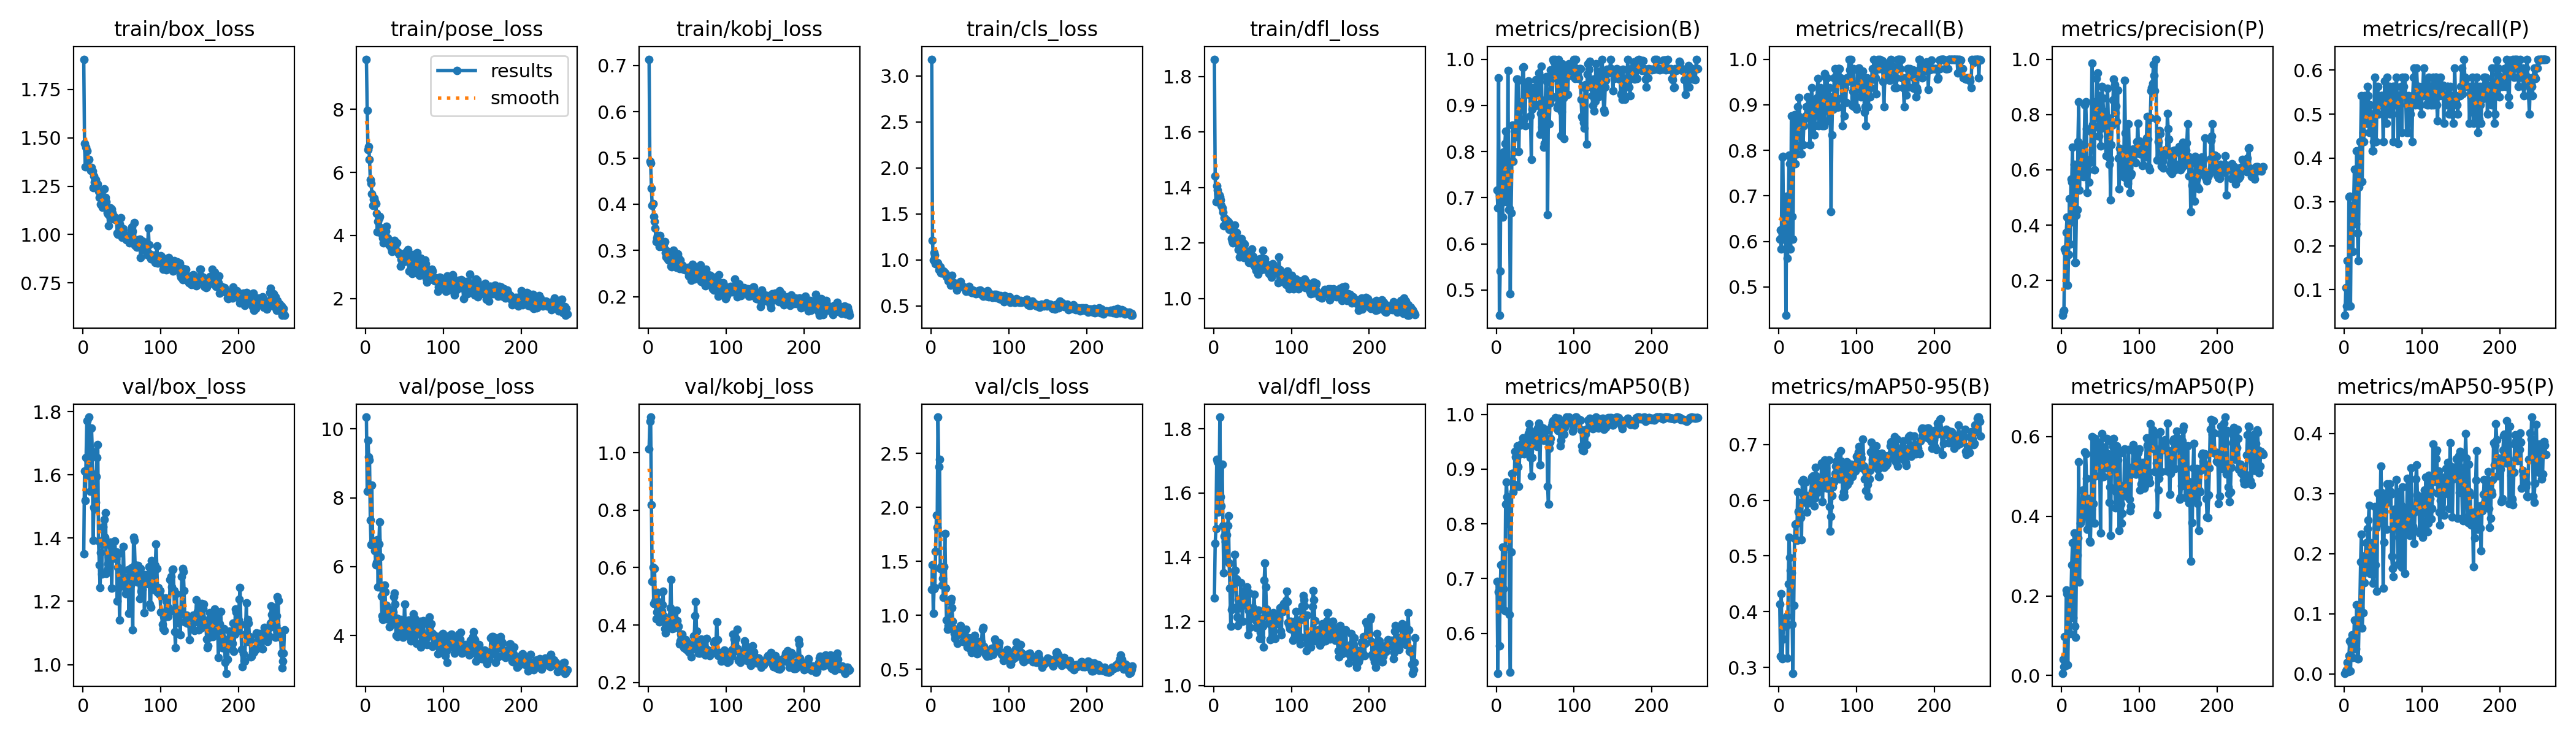

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename='/content/runs/pose/train3/results.png', width=800)

Y al observar estas gráficas vemos que convergen a valores muy cercanos tanto en entrenamiento como en validación y por tanto podemos concluir que el modelo afinado generaliza bastante bien.

## 5. Generación de predicciones con el modelo afinado

Y por último, podemos usar el set de prueba (disponible en la carpeta `../datasets/padel_pose/test/images`) para generar predicciones sobre nuevos datos usando el modelo afinado.

Comencemos cargando el modelo afinado:

In [ ]:
from ultralytics import YOLO
model = YOLO('/content/runs/pose/train3/weights/best.pt')

Y ahora generemos predicciones sobre la totalidad del set de prueba:

In [ ]:
import cv2

# Leer la imagen
image = cv2.imread('/content/IR_0036_procesada.jpg')

# Convertir a escala de grises
image2 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Redimensionar la imagen a 640x640
image3 = cv2.resize(image2, (640, 640))

# Guardar la imagen procesada
cv2.imwrite('/content/IR_0036_procesada.jpg', image3)


True

In [ ]:
preds = model('/content/drive/MyDrive/train_pose/data_augmented/test/images')


image 1/30 /content/drive/MyDrive/train_pose/data_augmented/test/images/16b6a911-thermal_IR_0032_aug1.jpg: 256x320 1 persona, 62.3ms
image 2/30 /content/drive/MyDrive/train_pose/data_augmented/test/images/16b6a911-thermal_IR_0032_aug2.jpg: 256x320 1 persona, 13.6ms
image 3/30 /content/drive/MyDrive/train_pose/data_augmented/test/images/16b6a911-thermal_IR_0032_aug3.jpg: 256x320 1 persona, 15.4ms
image 4/30 /content/drive/MyDrive/train_pose/data_augmented/test/images/16b6a911-thermal_IR_0032_aug4.jpg: 256x320 1 persona, 11.0ms
image 5/30 /content/drive/MyDrive/train_pose/data_augmented/test/images/16b6a911-thermal_IR_0032_aug5.jpg: 256x320 1 persona, 14.6ms
image 6/30 /content/drive/MyDrive/train_pose/data_augmented/test/images/16b6a911-thermal_IR_0032_orig.jpg: 256x320 1 persona, 11.0ms
image 7/30 /content/drive/MyDrive/train_pose/data_augmented/test/images/47139875-thermal_IR_0028_aug1.jpg: 256x320 1 persona, 11.6ms
image 8/30 /content/drive/MyDrive/train_pose/data_augmented/test/ima

Y para ver las predicciones generadas modemos simplemente acceder a una predicción individual y usar el método "show" para dibujar la imagen junto con la máscara de segmentación predicha:

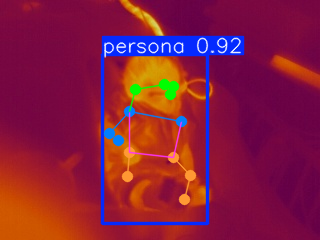

In [ ]:
# Mostrar una predicción
preds[5].show()